# YouTube Video Engagement Analysis Project

## Notebook 3: Model Development and Training

In this notebook, we will develop and train a regression model to identify key factors
that drive high engagement (likes, comments, shares) on electric scooter videos.

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [2]:
# Load data
df = pd.read_csv('youtube_metadata.csv')

# Feature engineering
# Convert counts to integers
df['view_count'] = df['view_count'].astype(int)
df['like_count'] = df['like_count'].astype(int)
df['dislike_count'] = df['dislike_count'].astype(int)
df['comment_count'] = df['comment_count'].astype(int)

# Convert published_at to datetime
df['published_at'] = pd.to_datetime(df['published_at'])

# Extract relevant features for analysis
df['duration_seconds'] = pd.to_timedelta(df['duration']).dt.total_seconds()
df['tags_count'] = df['tags'].apply(len)

# Combine tags and description for text analysis
df['text'] = df['tags'].apply(lambda x: ' '.join(x)) + ' ' + df['description']


In [3]:
# Remove non UTF-8 Characters to process text
def keep_utf8_characters(text):
    try:
        # Encode to utf-8 and decode to remove invalid characters
        return text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')
    except:
        # If there's an error, return an empty string
        return ''

df['text'] = df['text'].apply(keep_utf8_characters)

TF-IDF is a natural language processing (NLP) technique that's used to evaluate the importance of different words in a sentence. TF-IDF stands for term frequency-inverse document frequency and it is a measure, used in the fields of information retrieval (IR) and machine learning, that can quantify the importance or relevance of string representations (words, phrases, lemmas, etc) in a document amongst a collection of documents

The max_features here selects the total number of features which are extracted from the 'text' column. 

In [4]:
# Text processing: TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Join TF-IDF features with the original DataFrame
df = pd.concat([df, tfidf_df], axis=1)


In [5]:
# Calculate percentiles for classification thresholds
percentile_33 = df['view_count'].quantile(0.33)
percentile_66 = df['view_count'].quantile(0.66)

# Define engagement classes
def classify_engagement(likes):
    if likes <= percentile_33:
        return 0
    elif likes <= percentile_66:
        return 1
    else:
        return 2

df['engagement_class'] = df['view_count'].apply(classify_engagement)

The input will have the shape [1,103]

In [9]:
# Prepare data for modeling
features = ['view_count', 'duration_seconds', 'tags_count'] + list(tfidf_vectorizer.get_feature_names_out())
X = df[features]
y = df['engagement_class']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate model performance
y_pred = model.predict(X_test)
y_pred_round = [round(x) for x in y_pred]

conf_matrix = confusion_matrix(y_test, y_pred_round)
mse = mean_squared_error(y_test, y_pred_round)
cr = classification_report(y_test, y_pred_round)

print(f'Mean Squared Error: {mse}')
print(cr)


Mean Squared Error: 0.07142857142857142
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         4

    accuracy                           0.93        14
   macro avg       0.96      0.89      0.91        14
weighted avg       0.94      0.93      0.92        14



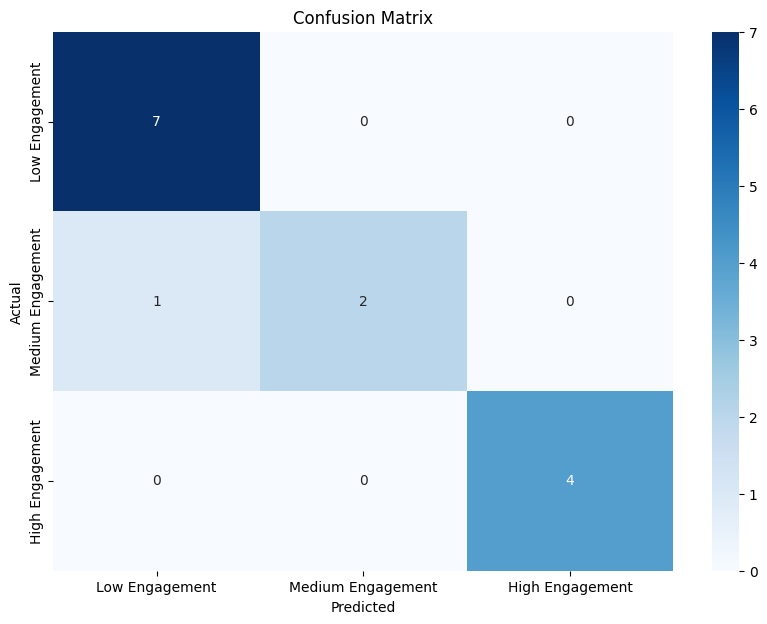

In [10]:
# Define the labels
labels = ['Low Engagement', 'Medium Engagement', 'High Engagement']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
X_test.shape

(14, 103)

In [36]:
# Save model for deployment
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

In [ ]:
import boto3

# Upload the model to S3
client = boto3.client(
    's3',
    aws_access_key_id="",
    aws_secret_access_key="",
)
client.upload_file('model.pkl', 'electric-scooters', 'model/model.pkl')

## After Notebook 4 for setup, you can run this code to test

In [19]:
input_data = X_test.tolist()[3]
input_label = y_test.tolist()[3]

In [17]:
print('Total number of features:',len(input_data))

Total number of features: 103


In [79]:
import requests

labels = {0:'Low Engagement', 1:'Medium Engagement', 2:'High Engagement'}

# Replace with your API Gateway invoke URL
api_url = 'http://YOUR_PUBLIC_IP_DNS.ap-southeast-2.compute.amazonaws.com:5000/predict'
response = requests.post(api_url, json={'input': input_data})
response.json()
prediction = labels[response.json()['prediction']]
prediction

'Low Engagement'

The correct label, we were expecting

In [14]:
tru_pred = labels[input_label]
tru_pred

'Low Engagement'